# Análisis de Series de Tiempo utilizando: ARIMA, LSTM y Prophet

Este notebook es una referencia y ejemplo de la utilización de tres modelos distintos para trabajar con predicción en series temporales.

Una serie de tiempo es una secuencia de observaciones medidas en intervalos de tiempo regulares, dependiendo de la frecuencia de las mediciones, la granularidad de los datos puede estar a nivel de hora, día, mes, año, cuatrimestre, trimestre, etc.


Voy a trabajar con dos datasets:
* `MarketArrivals`
* `AirPassengers`

In [5]:
import matplotlib.pyplot as plt
import seaborn as sn
plt.style.use('fivethirtyeight')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,9)

import numpy as np
import pandas as pd
#import fbprophet as Prophet
#import cython

from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

import stldecompose as stl


In [6]:
df_market = pd.read_csv('MarketArrivals.csv', parse_dates = ['date'], index_col = 'date')
df_market.sample(5)

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city
date,,,,,,,,,
2007-09-01,PUNE(MS),September,2007,113573,800,1669,1230,MS,PUNE
2000-07-01,CHAKAN(MS),July,2000,14965,52,260,172,MS,CHAKAN
2007-03-01,MANMAD(MS),March,2007,144378,513,697,638,MS,MANMAD
2011-10-01,PUNE(MS),October,2011,192835,596,1142,873,MS,PUNE
2013-06-01,BANGALORE,June,2013,337186,843,1840,1517,KNT,BANGALORE


/home/ignacio/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


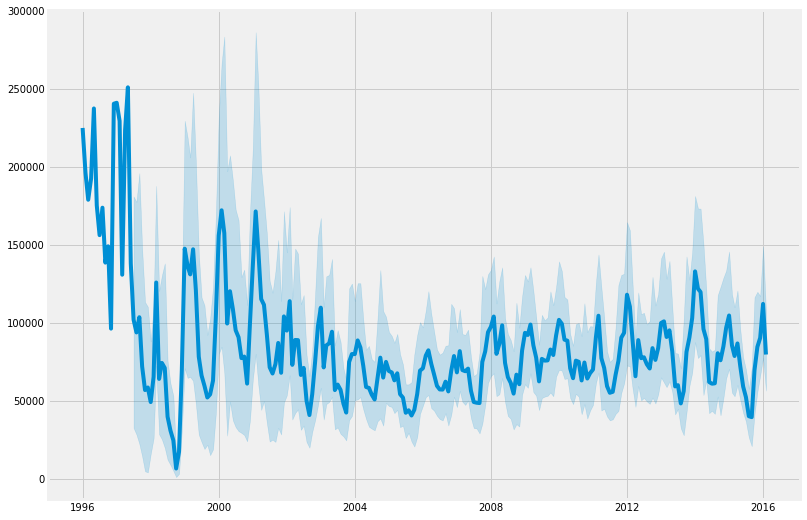

In [7]:
sn.lineplot(data = df_market.quantity);

In [8]:
df_passengers = pd.read_csv('airline-passengers.csv', index_col = 'Month', parse_dates = ['Month'])
df_passengers.sample(5)

,Passengers
Month,
1952-10-01,191
1958-09-01,404
1959-01-01,360
1956-06-01,374
1953-02-01,196


In [9]:
df_passengers.index = pd.to_datetime(df_passengers.index)

In [10]:
df_passengers.dtypes

Passengers    int64
dtype: object

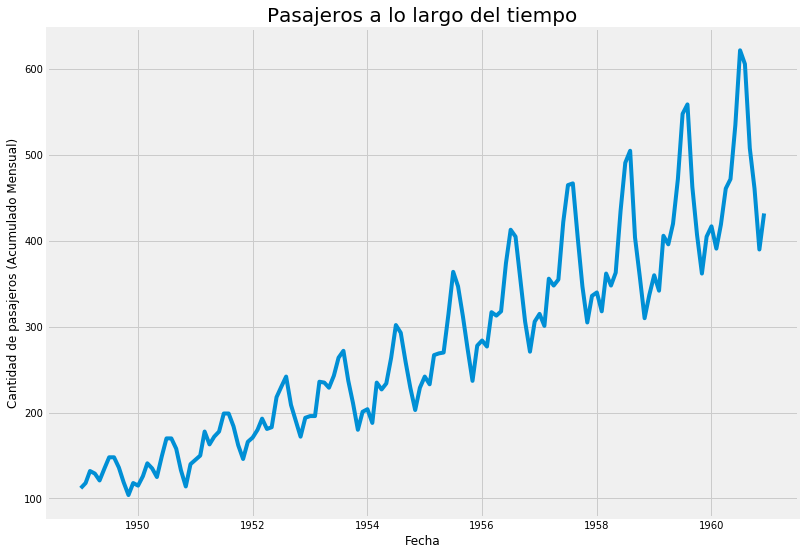

In [11]:
sn.lineplot(data = df_passengers.Passengers)
plt.title('Pasajeros a lo largo del tiempo', fontsize = 20)
plt.ylabel('Cantidad de pasajeros (Acumulado Mensual)')
plt.xlabel('Fecha');

Los valores de una serie de tiempo se pueden ver influenciados por dos componentes de la misma:

* **Componentes Sistemáticos:** Componentes que tienen consistencia o recurrencia y pueden ser descritos o modelados (por ejemplo la cantidad de días que faltan para el siguiente feriado o fin de semana largo).
* **Componentes No-Sistemáticos:** Componentes que no pueden ser modelados directamente (por ejemplo lo que estaba pensando una persona al momento de decidir qué caja de cereal comprar).

Toda serie de tiempo puede descomponerse en las siguientes componentes sistemáticas:

* **Nivel Base:** Valor medio de la serie.
* **Tendencia:** Observada en las pendientes positivas y negativas de la serie. Es el incremento o decremento de los valores en la serie.
* **Periodicidad:** Observada en los patrones repetitivos observados a lo largo del tiempo en intervalos regulares de tiempo.
* **Error:** Variación aleatoria.


Notar que no todas las series de tiempo tienen tendencia o periodicidad.

En la serie de pasajeros a lo largo del tiempo, observamos tanto una **tendencia** general al alza como una periodicdad en que el patrón subida y bajada de clientes se repite a lo largo de la serie.

Si un patron no está condicionado por eventos de calendario fijos (por ejemplo festivos) entonces es un patrón ciclico, de lo contrario es el efecto de la estacionaldiad. La diferencia está en que los eventos cíclicos están condicionados por otros factores como hitos socio-econónicos u otros influenciados por el negocio.

-------
## Series de tiempo aditivas y multiplicaticas

Dependiendo de la naturaleza de la tendencia y la estacionalidad, se puede modelar la serie de tiempo como `aditiva` o `multiplicativa`:

### **Serie Aditiva:**
> $$Valor = Nivel Base + Tendencia + Periodicidad + Error$$
> Un modelo aditivo es lineal cuando los cambios a lo largo del tiempo ocurren consistentemente en la misma cantidad.
> * Una **tendencia** lineal es una linea recta.
> * Una **periodicidad** lineal tiene la misma frecuencia (ancho de los ciclos, período) y amplitud (altura de los ciclos).

### **Serie multiplicativa:**
> $$Valor = Nivel Base x Tendencia x Periodicidad x Error$$
> Un modelo multiplicativo es no-lineal, los cambios aumentan o disminuyen a lo largo del tiempo.
> * Una **tendencia** no-lineal es curva.
> * Una **periodicidad** no-lineal tiene incrementos o decrementos en la frecuencia y/o amplitud a lo largo del tiempo.


La librería `statsmodels` permite descomponer una serie de tiempo, asumiendo aditividad o multiplicidad, como una combinación de sus partes. Notar, sin embargo, que ambas descomposiciones producen valores, por lo que queda a criterio nuestro decidir cual es la correcta, los datos de la vida real son complejos y pueden tener componentes periodicas mezcladas con componentes no periodicas u otra combinación.

Para el dataset de `AirPassengers`:

Notar que le estamos pasando explícitamente el argumento `freq`, éste le dice al modelo la frecuencia con la que se midieron los datos, en nuestro caso, tomamos un dato cada mes, por lo que la frecuencia sería $12$, ya que hay $12$ meses en $1$ año.

El parámetro `freq` de seasonal_decompose se debe setear a mano, al menos hasta la versión $0.10.0$ de statsmodels con la que estoy trabajando. La forma de definirlo es la siguiente: "*¿Cada cuantas observaciones queremos tratar de capturar un patrón periodico?*", en nuestro caso, buscaremos un patrón anual, pero bajo otros casos se pueden encontrar patrones diarios o semanales. Por ejemplo, si tuviesemos datos de ventas registradas cada 30 minutos, podríamos querer encontrar un patrón semanal o diario.


> **En el caso de buscar un patrón diario:**
>$$
freq = \frac{60\cdot 24 [hrs]}{30}
$$
>
> Es decir, estamos buscando un patrón cada $48$ registros que son capturados durante todo un dia.

> **En el caso de que buscásemos un patrón semanal:**
> $$
freq = \frac{60\cdot 24[hrs] \cdot 7[dias]}{30}
$$

In [17]:
# Descomposicion multiplicativa
decomp_mul_passengers = seasonal_decompose(df_passengers.Passengers.values, model='multiplicative', freq = 12)

# Descomposicion aditiva
decomp_add_passengers = seasonal_decompose(df_passengers.Passengers.values, model = 'additive', freq = 12)

Los objetos devueltos por statsmodels luego de la descomposición son de tipo `DecomposeResult`, estos implementan algunas funciones útiles, como por ejemplo el método `plot()`

In [13]:
type(decomp_add_passengers)

statsmodels.tsa.seasonal.DecomposeResult

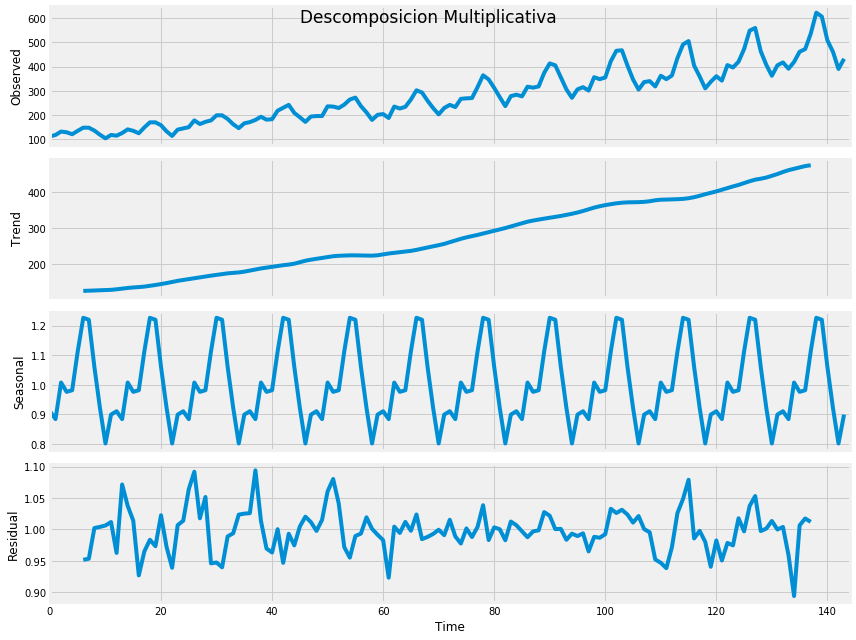

In [18]:
decomp_mul_passengers.plot().suptitle('Descomposicion Multiplicativa', fontsize = 17);

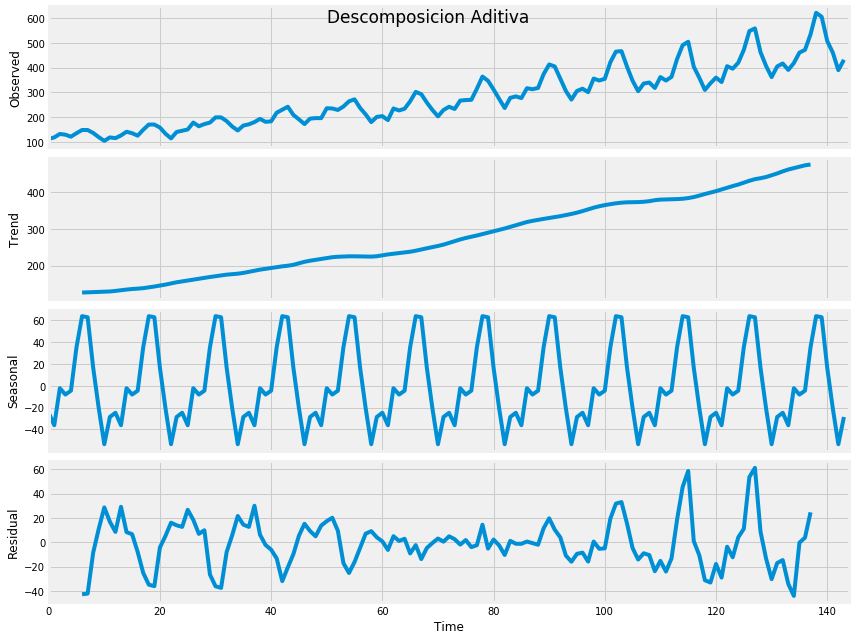

In [15]:
decomp_add_passengers.plot().suptitle('Descomposicion Aditiva', fontsize = 17);

* Ambos métodos entregan resultados similares.
* Podemos observar que los residuos aún conservan cierto patrón que no fue correctamente separado en la serie, debiesemos esperar que estos se viesen como ruido.
* Observamos una tendencia hacia el alza.
* Hay una clara periodicidad en la cantidad de pasajeros que se observan durante el tiempo.

Para el dataset de `MarketArrivals`:

Usamos la misma frecuencia porque los datos se midieron por mes también.

In [20]:
# Descomposicion multiplicativa
decomp_mul_market = seasonal_decompose(df_market.quantity.interpolate().values, model = 'multiplicative', freq = 12)

# Descomposicion aditiva
decomp_add_market = seasonal_decompose(df_market.quantity.interpolate().values, model = 'additive', freq = 12)

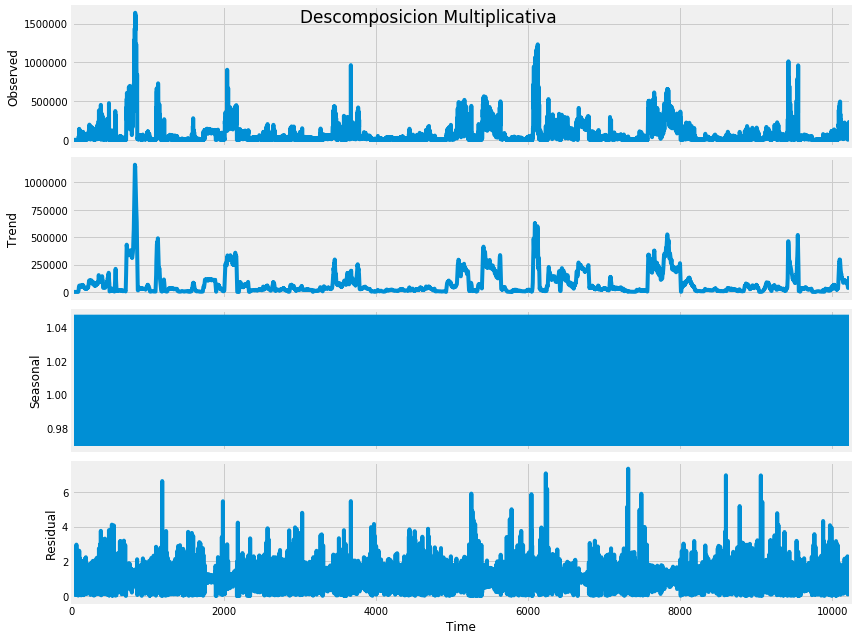

In [21]:
decomp_mul_market.plot().suptitle('Descomposicion Multiplicativa', fontsize = 17);

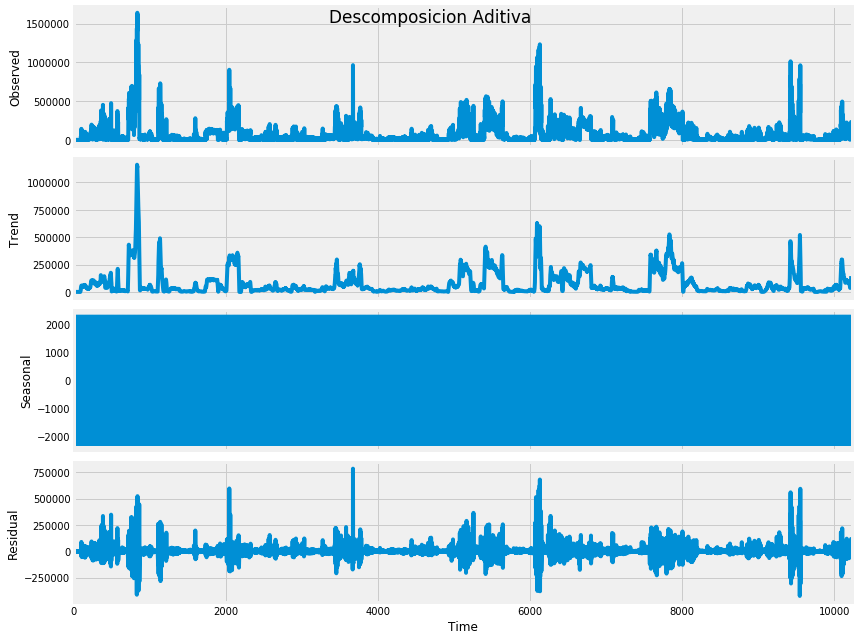

In [23]:
decomp_add_market.plot().suptitle('Descomposicion Aditiva', fontsize = 17);

* Podemos ver que en este caso ambas aproximaciones ingenuas fallan en separar la tendencia de la estacionalidad y los residuos.
* El gráfico de la componente estacional nos indica que el modelo no logró capturar nada últil en este aspecto.


`interpolate` realiza una interpolación (por defecto lineal) cuando encuentra valores faltantes.


Existen descomposiciones más avanzadas como *Loess* o *STL*.

In [24]:
decomp_stl_market = stl.decompose(df_market.quantity.interpolate().values)

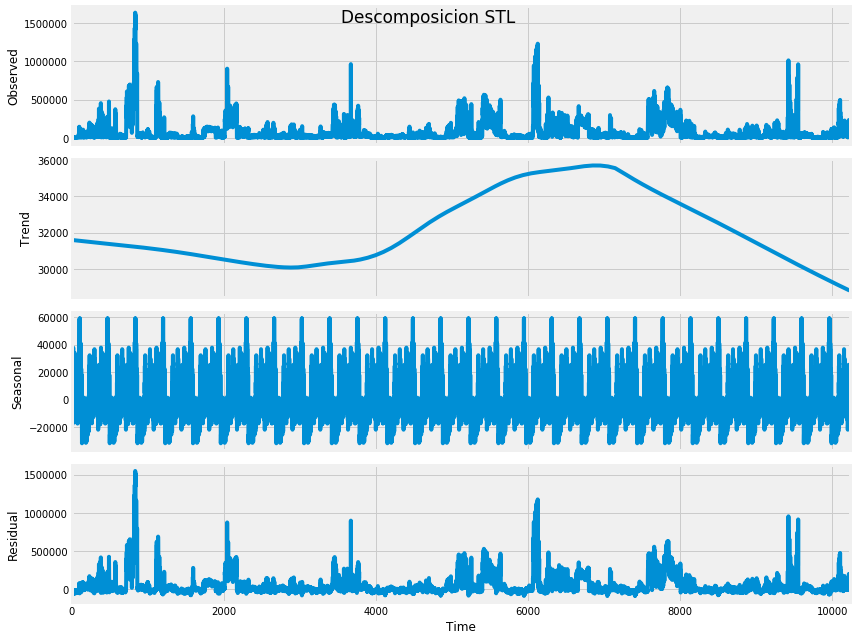

In [25]:
decomp_stl_market.plot().suptitle('Descomposicion STL', fontsize = 17);

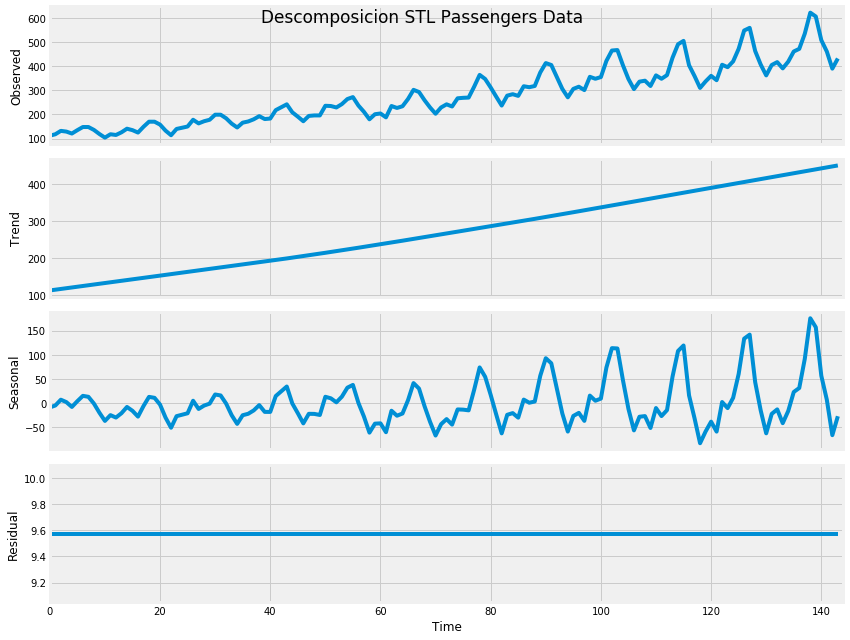

In [26]:
decomp_stl_passengers = stl.decompose(df_passengers.Passengers.interpolate().values)
decomp_stl_passengers.plot().suptitle('Descomposicion STL Passengers Data', fontsize = 17);

Si llegamos a ver que el gráfico de los residuos es constante e igual a cero para estos, esto nos indica que nuestras descomposiciones ingenuas (asumimos que las series eran o solo multiplicativas o solo aditivas) no fueron capaces de separar el ruido de las series. También puede estar pasando que la serie temporal tiene muy poco ruido o incluso que fue artificialmente alterada con una distribución de ruido simple.

* Podemos ver que la serie estacional crece en amplitud desde el registro 80 en adelante.

----
## Sobre stationality (estacionalidad/desplazamiento, pero en el sentido de 'movimiento' de la serie)

El desplazamiento (stationality) de una serie es una propiedad de la misma. Una serie estacionaria es aquella donde los valores de la serie no son una función del tiempo, es decir, las propiedades estáticas  de la serie, como la media, varianza y autocorrelación son constantes a lo largo del tiempo.

* La autocorrelación de una serie es la correlación de una serie con sus valores previos.

Una serie de tiempo estacionaria carece de efectos estacionales (seasonality).

<img src = 'stationary-and-non-stationary-time-series.png'>

La importancia de identificar estacionalidad (stationality) es porque la mayoría de los métodos de forecast están diseñados para trabajar on series de tiempo estacionarias (stationary time series), por lo que el primer paso antes de hacer forecast debiese ser realizar transformaciones sobre la serie para poder convertirla a una estacionaria. 

* Es posible convertir casi cualquier serie de tiempo no-estacionaria en una estacionaria aplicando transformaciones.


## Métodos para convertir una serie no estacionaria en una estacionaria

1. Diferenciación

2. Aplicar logaritmo a la serie

3. Aplicar la n-ésima raíz a la serie

4. Combinar las aproximaciones anteriores

El método más común y conveniente para estacionalizar una serie de tiempo es mediante diferenciación, al menos una vez, hasta que se convierta en una aproximadamente estacionaria.

### Diferenciación de una serie temporal

Sea $Y_t$ el valor de la serie en el tiempo $t$, entonces la primera diferencia de la serie es: $\Delta Y = Y_t - Y_{t-1}$. En otras palabras, diferenciar una serie no es más que restar el valor anterior al actual.

Si la primera diferenciación no hace la serie estacionaria, entonces se puede seguir diferenciando la serie hasta hacerla estacionaria.

Diferenciar una serie temporal hace que el forecast sea más fácil y más confiable. Por ejemplo, los modelos autoregresivos de forecast son escencialmente modelos de regresión lineal que utilizan un cierto lag de la serie misma para hacer las predicciones.

Sabemos que una regresión lineal funciona mejor si los predictores (variables de la matriz de diseño X) no están correlacionados fuertemente entre si. Por lo tanto, estacionalizar la serie soluciona el problema ya que remueve correlaciones, hace que los predictores (lag de la serie) en el modelo de forecast sean cercanos a independientes entre si.

-----
## Chequeo de estacionalidad

La estacionalidad de una serie puede detectada mirando la gráfica de la misma, como hicimos anteriormente. Otro método es dividir la serie en dos o mas partes contiguas y computando la media, varianza y autocorrelación, si los estadísticos difieren demasiado, entonces la serie probablemente no sea estacionaria.

De forma más cuantitativa se puede usar pruebas estadísticas llamadas 'Unit Root Tests'. Estas tienen multiples variantes:

1. Augmented Dickey Fuller test (ADF Test)
2. Kwiatkowski-Phillips-Schmidt-Shin - KPSS test (trend stationary)
3. Phillips Perron Test (PP Test)

La más utilizada es ADF, donde la hipótesis nula es tal que asume que la serie temporal posee una raiz única y es no estacionaria. Luego, si el p-valor de la prueba ADF es menor al nivel de significancia deseado (0.05, 0.01, 0.1, etc.), se puede rechazar la hipótesis nula y asumir estacionalidad al determinado nivel de confiaza.

La prueba de KPSS es usada para probar estacionalidad de la tendencia. La interpretación de la hipótesis nula y del p-valor es opuesta a la de la prueba ADF.

* Ambas pruebas están incluidas dentro de la librería `statsmodels`.

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss

> ### ADF

In [210]:
fuller_market = adfuller(df_market.quantity, autolag = 'AIC')
print('ADF statistic: {}'.format(fuller_market[0]))
print('ADF p-value: {}'.format(fuller_market[1]))


ADF statistic: -8.568349524394955
ADF p-value: 8.32745527536447e-14


Observamos que el p-valor nos permite rechazar la hipótesis nula de que la serie es no-estacionaria con un altísimo grado de confianza ($1-8.33\cdot10^{-14}$)

In [211]:
fuller_passenger = adfuller(df_passengers.Passengers, autolag = 'AIC')
print('ADF statistic: {}'.format(fuller_passenger[0]))
print('ADF p-value: {}'.format(fuller_passenger[1]))


ADF statistic: 0.8153688792060456
ADF p-value: 0.991880243437641


Para el caso de registros de pasajeros de la aerolínea, podemos ver que el p-valor no nos permite rechazar la hipótesis nula con un nivel de confiazan ni cercano a lo razonable, esto se condice con lo que se observa en la gráfica de la serie temporal (mirar el gráfico, se ve una clara tendencia al alza)

Notar que podemos chequear estacionalidad alrededor de una constante o de la tendencia, por defecto estos métodos chequean tendencia alrededor de una cosntante pero se le puede especificar que la chequeen al rededor de la tendencia asignando `c` (constant) o `ct` (constante alrededor de la tendencia) al argumento `regression`, por ejemplo, para el caso de los datos de pasajeros:

In [215]:
fuller_passenger_ct = adfuller(df_passengers.Passengers, autolag = 'AIC', regression = 'ct')
print('ADF statistic: {}'.format(fuller_passenger_ct[0]))
print('ADF p-value: {}'.format(fuller_passenger_ct[1]))


ADF statistic: -2.100781813844679
ADF p-value: 0.5456589343124496


El p-valor aún no es suficiente como para asumir estacionalidad alrededor de la tendencia, sin embargo, recuperamos cierta parte del comportamiento pues disminuye este.

-----
## Quitar la tendencia de una serie de tiempo

Hay diversos métodos:
1. Restar la linea de mejor fit de la serie. Esta puede ser obtenida usando una regresión lineal o cuadrática.

2. Restar la componente de tendencia obtenida de la descomposición que se vio anteriormente.

3. Restar la media.

4. Aplicar un filtro como Baxter-King (`statsmodels.tsa.filters.bkfilter`) o el filtro Hodrick-Prescott (`statsmodels.tsa.filters.hpfilter`) para remover las lineas de tendencia de la media móvil o de las componentes ciclicas.

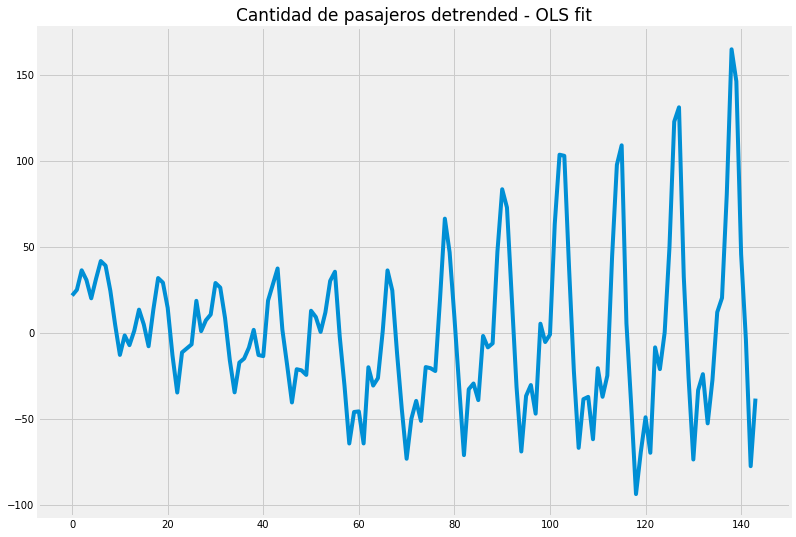

In [233]:
from scipy import signal

# Usando fit lineal OLS
detrended_passenger_ols = signal.detrend(df_passengers.Passengers.values)

plt.plot(detrended_passenger_ols)
plt.title('Cantidad de pasajeros detrended - OLS fit', fontsize = 17);

Substrayendo la componente de tendencia de la descomposición periódica:

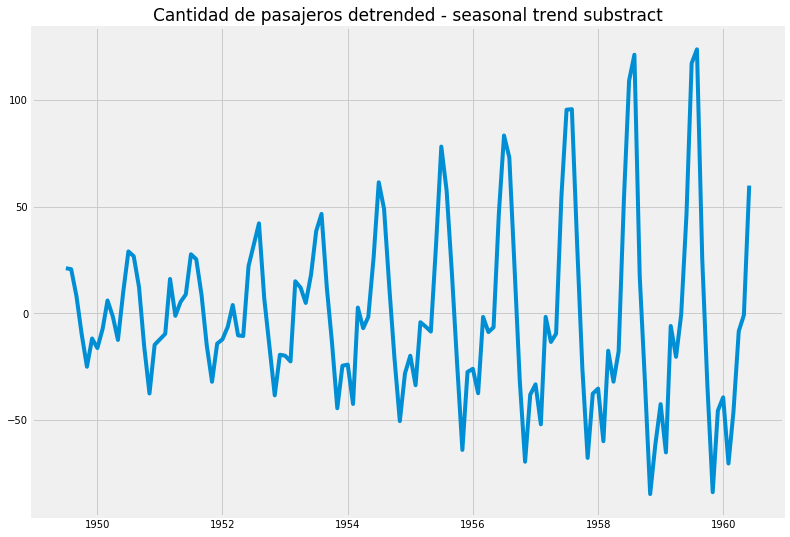

In [234]:
from statsmodels.tsa.seasonal import seasonal_decompose

detrended_passenger_seasonal = df_passengers.Passengers - decomp_add_passengers.trend

plt.plot(detrended_passenger_seasonal)
plt.title('Cantidad de pasajeros detrended - seasonal trend substract', fontsize = 17);